---
# Cairo University Faculty of Engineering
## Deep Learning 
## Assignment 5_2

---

Please write your full name here
- **Name** : Mariam Magued Habib Bebawy

## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. 
Within this notebook you will find instructions in each section for how to complete the assignment. 

Pay close attention to the instructions. Feel free to add extra cells into the notebook as required.

### Let's get started!

We'll start by running some imports, and loading the dataset. You are free to make further imports throughout the notebook as you wish. 

In [ ]:
import tensorflow as tf
from scipy.io import loadmat

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

For this assignmnet, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. 

- If using Colab: You should store these files in Drive.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [ ]:
### Using Colab only
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [105]:
# Load the dataset from your Drive folder

train = loadmat('gdrive/MyDrive/datasets/MATFILES/train_32x32.mat')
test = loadmat('gdrive/MyDrive/datasets/MATFILES/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [106]:
train_X = train['X']
train_y = train['y']
test_X = test['X']
test_y = test['y']
train_X.shape

(32, 32, 3, 73257)

In [107]:
train_X = np.transpose(train_X, (3,0,1,2))
test_X = np.transpose(test_X, (3,0,1,2))
train_X.shape

(73257, 32, 32, 3)

In [108]:
# choose color channel axis ----> last axis ----> axis=-1
train_X_gray = np.mean(train_X, keepdims=True, axis=-1)
test_X_gray = np.mean(test_X, keepdims=True, axis=-1)
train_X_gray.shape

(73257, 32, 32, 1)

In [109]:
def display_img(imgSet):
    sample = 10
    randomize = np.random.randint(1, imgSet.shape[0], size=sample)
    fig = plt.figure(figsize=(20,10))
    for ifig, ipic in enumerate(randomize):
        fig.add_subplot(2, 5, ifig+1)
        if imgSet.shape[-1] == 1:
            plt.imshow(imgSet[ipic, :, :, 0], cmap='gray')
        else:
            plt.imshow(imgSet[ipic])
        plt.axis('off')

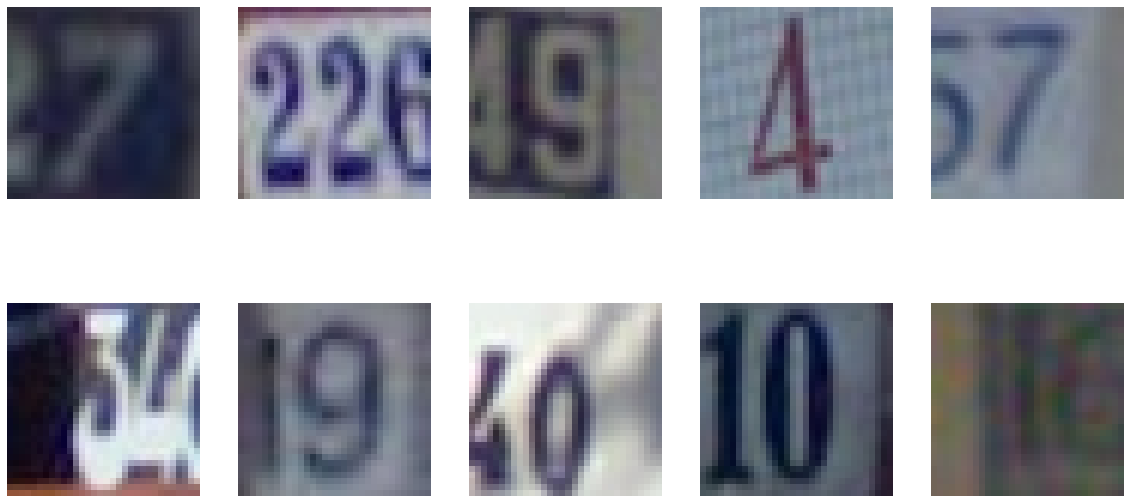

In [110]:
display_img(train_X)

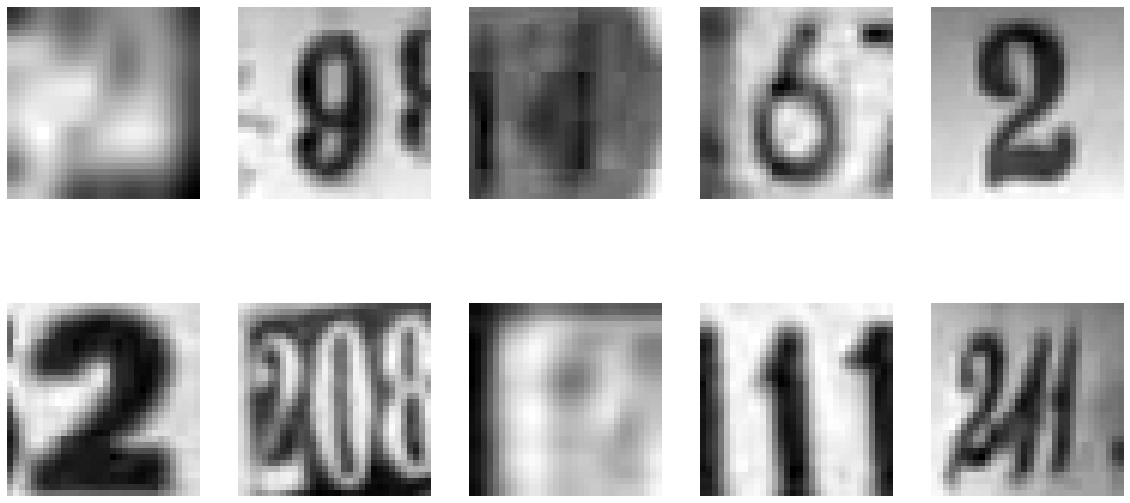

In [111]:
display_img(train_X_gray)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least one callback during training, like a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [112]:
train_y = train_y - 1
test_y = test_y - 1

In [113]:
mod_X_train, mod_X_val, mod_y_train, mod_y_val = train_test_split(train_X_gray, train_y, test_size=0.2)
print(mod_X_train.shape)
print(mod_y_train.shape)

(58605, 32, 32, 1)
(58605, 1)


In [119]:
def build_model(input_shape):
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(64, activation='relu'), 
        layers.Dense(64, activation='relu'), 
        layers.Dense(64, activation='relu'), 
        layers.Dense(10, activation='softmax')
    ])
    return model

In [124]:
input_shape = train_X_gray.shape[1:]
model = build_model(input_shape)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 1024)              0         
                                                                 
 dense_28 (Dense)            (None, 64)                65600     
                                                                 
 dense_29 (Dense)            (None, 64)                4160      
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 10)                650       
                                                                 
Total params: 74,570
Trainable params: 74,570
Non-trainable params: 0
_________________________________________________________________


In [125]:
model.compile(
    optimizer = 'adam', 
    # loss = 'categorical_crossentropy', 
    loss = 'sparse_categorical_crossentropy', 
    metrics = 'accuracy'
)

In [126]:
callback_checkpoint = ModelCheckpoint(
    filepath = 'model/best_model', 
    save_weights_only = True, 
    monitor = 'val_accuracy', 
    save_best_only = True
)

In [127]:
history = model.fit(
    mod_X_train, mod_y_train, 
    epochs = 30, 
    validation_data = (mod_X_val, mod_y_val), 
    callbacks = [callback_checkpoint], 
    batch_size = 256
)

Epoch 1/30
229/229 [==============================] - 1s 5ms/step - loss: 6.9289 - accuracy: 0.1307 - val_loss: 2.8394 - val_accuracy: 0.1577
Epoch 2/30
229/229 [==============================] - 1s 4ms/step - loss: 2.6772 - accuracy: 0.1917 - val_loss: 2.4669 - val_accuracy: 0.2209
Epoch 3/30
229/229 [==============================] - 1s 4ms/step - loss: 2.1717 - accuracy: 0.2914 - val_loss: 2.0060 - val_accuracy: 0.3616
Epoch 4/30
229/229 [==============================] - 1s 4ms/step - loss: 1.8366 - accuracy: 0.3920 - val_loss: 1.7724 - val_accuracy: 0.4461
Epoch 5/30
229/229 [==============================] - 1s 4ms/step - loss: 1.6199 - accuracy: 0.4687 - val_loss: 1.5308 - val_accuracy: 0.5087
Epoch 6/30
229/229 [==============================] - 1s 4ms/step - loss: 1.4665 - accuracy: 0.5231 - val_loss: 1.4316 - val_accuracy: 0.5511
Epoch 7/30
229/229 [==============================] - 1s 4ms/step - loss: 1.3801 - accuracy: 0.5598 - val_loss: 1.3378 - val_accuracy: 0.5754
Epoch 

In [128]:
model.evaluate(test_X_gray, test_y)

814/814 [==============================] - 2s 2ms/step - loss: 1.1143 - accuracy: 0.6742


[1.1143275499343872, 0.6741702556610107]

In [129]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

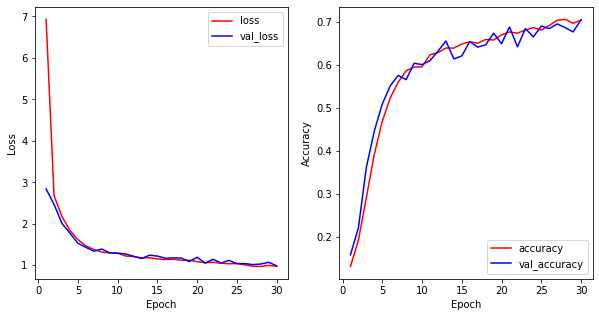

In [130]:
fig = plt.figure(figsize=(10,5))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'r-')
plt.plot(epochs, val_loss, 'b-')
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

fig.add_subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'r-')
plt.plot(epochs, val_accuracy, 'b-')
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model **must** use fewer trainable parameters than your MLP model.
* Compile and train the model (recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least one callback during training, like a ModelCheckpoint callback.
* **You should aim to beat the MLP model performance with fewer parameters!**
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [132]:
def build_model_cnn(input_shape):
    model = tf.keras.Sequential([
        Conv2D(8, 5, input_shape=input_shape),
        MaxPooling2D(2, strides=2), 
        BatchNormalization(), 
        Dropout(0.3), 

        Conv2D(16, 5),
        MaxPooling2D(2, strides=2), 
        BatchNormalization(), 
        Dropout(0.3), 

        Flatten(), 
        Dense(64, activation='relu'), 
        Dense(32, activation='relu'), 
        Dense(10, activation='softmax')
    ])
    return model

In [133]:
model_cnn = build_model_cnn(input_shape)
model_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 8)        32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)        

In [134]:
model_cnn.compile(
    optimizer = 'adam', 
    # loss = 'categorical_crossentropy', 
    loss = 'sparse_categorical_crossentropy', 
    metrics = 'accuracy'
)

In [135]:
callback_checkpoint = ModelCheckpoint(
    filepath = 'model_cnn/best_model', 
    save_weights_only = True, 
    monitor = 'val_accuracy', 
    save_best_only = True
)

In [136]:
history = model_cnn.fit(
    mod_X_train, mod_y_train, 
    epochs = 30, 
    validation_data = (mod_X_val, mod_y_val), 
    callbacks = [callback_checkpoint], 
    batch_size = 256
)

Epoch 1/30
229/229 [==============================] - 8s 8ms/step - loss: 1.6332 - accuracy: 0.4493 - val_loss: 1.1199 - val_accuracy: 0.6618
Epoch 2/30
229/229 [==============================] - 1s 6ms/step - loss: 0.8485 - accuracy: 0.7405 - val_loss: 0.6766 - val_accuracy: 0.8018
Epoch 3/30
229/229 [==============================] - 1s 6ms/step - loss: 0.7107 - accuracy: 0.7836 - val_loss: 0.6362 - val_accuracy: 0.8125
Epoch 4/30
229/229 [==============================] - 1s 5ms/step - loss: 0.6482 - accuracy: 0.8041 - val_loss: 0.5356 - val_accuracy: 0.8469
Epoch 5/30
229/229 [==============================] - 1s 6ms/step - loss: 0.6084 - accuracy: 0.8145 - val_loss: 0.5160 - val_accuracy: 0.8516
Epoch 6/30
229/229 [==============================] - 1s 6ms/step - loss: 0.5847 - accuracy: 0.8238 - val_loss: 0.4973 - val_accuracy: 0.8590
Epoch 7/30
229/229 [==============================] - 1s 6ms/step - loss: 0.5622 - accuracy: 0.8301 - val_loss: 0.4715 - val_accuracy: 0.8666
Epoch 

In [137]:
model.evaluate(test_X_gray, test_y)

814/814 [==============================] - 4s 4ms/step - loss: 1.1143 - accuracy: 0.6742


[1.1143275499343872, 0.6741702556610107]

In [138]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

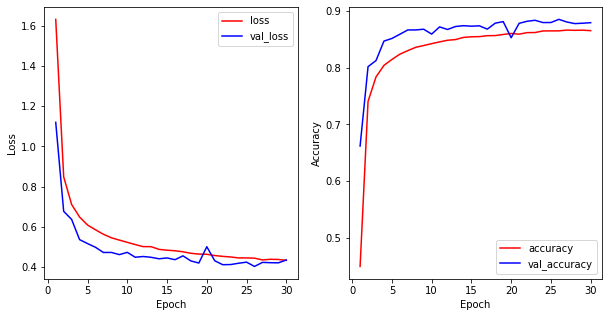

In [139]:
fig = plt.figure(figsize=(10,5))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'r-')
plt.plot(epochs, val_loss, 'b-')
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

fig.add_subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'r-')
plt.plot(epochs, val_accuracy, 'b-')
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## 4. Get model predictions
* Load the **best weights** for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [140]:
mlp = build_model(input_shape)
mlp.load_weights('model/best_model')
cnn = build_model_cnn(input_shape)
cnn.load_weights('model_cnn/best_model')

In [178]:
def display_pred(sample, model, imgSet, imgLabel):
    randomize = np.random.randint(1, imgSet.shape[0], size=sample)
    fig = plt.figure(figsize=(20,10))
    for ifig, ipic in enumerate(randomize):
        pred = model.predict(imgSet[ipic][np.newaxis])
        pred = np.reshape(pred, 10)
        # pred = np.argmax(pred)
        true = imgLabel[ipic] + 1 # since we subtracted 1 earlier from labels
        fig.add_subplot(5, 2, ifig*2+1)
        plt.axis('off')
        plt.imshow(imgSet[ipic, :, :, 0])
        plt.title('label: {} // pred: {}'.format(true, np.argmax(pred)))
        fig.add_subplot(5, 2, (ifig+1)*2)
        plt.bar(range(0,10), height=pred)

1/1 [==============================] - 0s 16ms/step


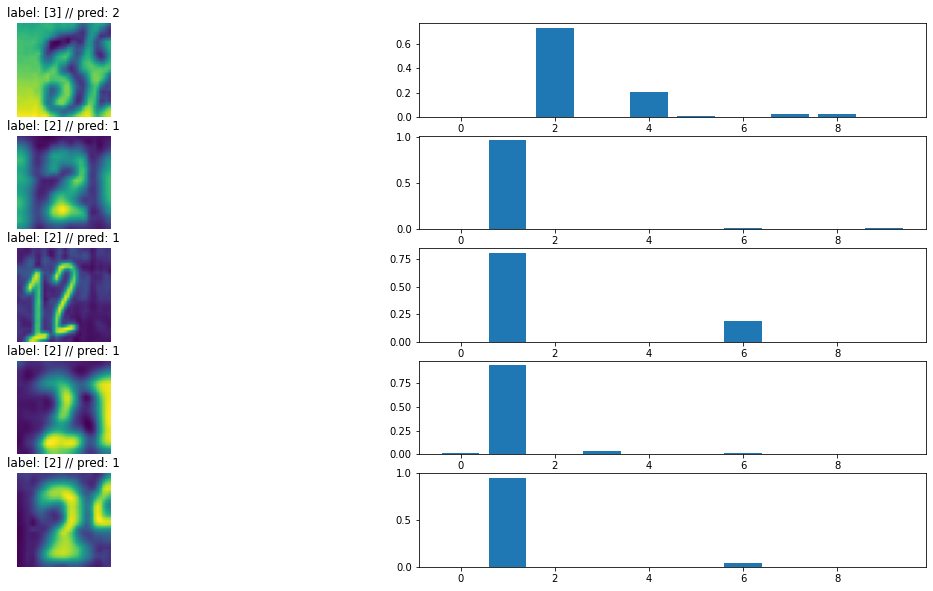

In [179]:
display_pred(sample=5, model=mlp, imgSet=test_X_gray, imgLabel = test_y)

1/1 [==============================] - 0s 13ms/step


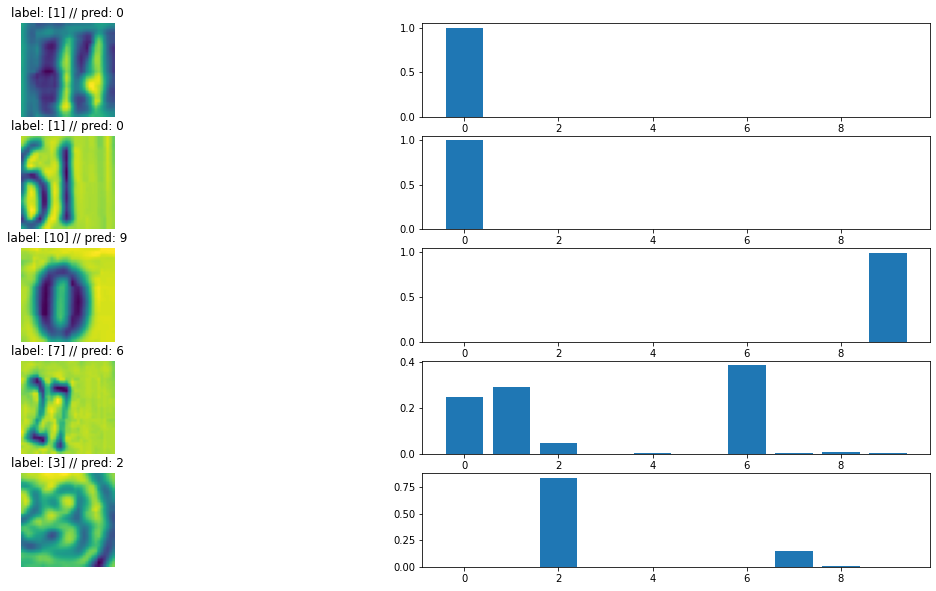

In [180]:
display_pred(sample=5, model=cnn, imgSet=test_X_gray, imgLabel = test_y)